In [73]:
import pandas as pd
import numpy as np
import spacy
import openpyxl

#Hanson's Reuters corpus cleansing (Formal Dataset)
import nltk
from nltk.corpus import reuters
nltk.download('reuters')
nltk.download('punkt')
reuters_sentences = reuters.sents()
reuters = [' '.join(x) for x in reuters_sentences]

import re
import csv
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
string_punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/hansonqin/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hansonqin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hansonqin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [72]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install --user -U nltk
!pip install openpyxl

     |████████████████████████████████| 45.7 MB 36.1 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
     |████████████████████████████████| 242 kB 9.1 MB/s eta 0:00:01


In [278]:
#Read in the training data
good_data = pd.read_csv('df_final_formality.csv')
good_data.drop(columns=good_data.columns[0],axis=1,inplace=True)
good_data.dropna(inplace=True)

#Importing the list of formal/informal words
formal_words = pd.read_excel('formal_words.xlsx',header=None)
formal_list = formal_words[0].values.tolist()
informal_words = pd.read_excel('informal_words.xlsx',header=None)
informal_list = formal_words[0].values.tolist()

In [280]:
good_data.shape

(89999, 2)

In [177]:
# Feature to identify Active/passive voice

# function to check the type of sentence
# 0 refers to passive, 1 refers to active
def checkForSentType(inputSentence):   
    # running the model on sentence
    getDocFile = nlp(inputSentence)
    
    # getting the syntactic dependency 
    getAllTags = [token.dep_ for token in getDocFile]
    
    # checking for 'agent' tag
    checkPassiveTest = any(['agent' in sublist for sublist in getAllTags])
    
    # checking for 'nsubjpass' tag
    checkPassiveTestTwo = any(['nsubjpass' in sublist for sublist in getAllTags])
    if checkPassiveTest or checkPassiveTestTwo:
        return 0
    else:
        return 1

# Spacy model imported
nlp = spacy.load("en_core_web_md")

# reading the list of test sentences

sentences = data['text'].head(5).values.tolist()

finalResult = []

# checking each sentence for its type
for sentence in sentences:
    result = checkForSentType(str(sentence))
    if(result==0):
        finalResult.append('Passive Sentence')
    else:
        finalResult.append('Active Sentence')
        
# storing the result in a new file and converting to csv
newDf = pd.DataFrame({'Sentences':sentences,'Answers':finalResult})

In [178]:
#Formal Pronouns
#Often third person
Formal_Pronouns = [
    "one","oneself","one's", 
    "who","whom","whomst","whose",
    "they","them","their","theirs","themself","themselves","theirself","theirselves",
    "it","its","itself",
    "he","him","himself","his",
    "she","her","herself","hers"
]

#Informal Pronouns
#Often first person
Informal_Pronouns = [
    "I","me","mine","mines","my","myself",
    "we","us","ourself","ourselves","our","ours",
    "you","your","yourself","yours","yourselves","y'all","yall","y'all's"
]

In [281]:
# Input: Labelled data in a dataframe
# Output: Dataframe of data with columns of features for each sentence (represented as rows)

def anvil_cleaner(data):
            
    #wored count
    data['Word Count']= data["text"].apply(lambda x: len(str(x).split()))
    
    #Counting number of formal pronouns
    data['Formal Pronoun'] = data["text"].apply(
        lambda x:len([w for w in str(x).lower().split() if w in Formal_Pronouns]))/data['Word Count']
        
    #Counting number of informal pronouns
    data['Informal Pronoun'] = data["text"].apply(
        lambda x:len([w for w in str(x).lower().split() if w in Informal_Pronouns]))/data['Word Count']
    
    #Counting number of contractions
    data['Contractions'] = data["text"].apply(lambda x: x.count("'"))/data['Word Count']
    
    #Identifying sentences with active voice
    data['Active Voice'] = data['text'].apply(checkForSentType)
    
    #Identifying sentences with passive voice (just opposite of active, since all sentences are active or passive)
    data['Passive Voice'] = 1 - data['text'].apply(checkForSentType)
        
    # Removing apostrophes so contractions are considered a single token
    data['clean_text'] = data['text'].apply(lambda x: re.sub("'", '', x))
    
    # Remove punctuation and stop words and lowercase the text
    data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(re.sub(
        r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words))

    #lemmatize
    #data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(w) for w in x.split()))


    #now engineer the features the model expects
    
    #Formal words count (normalized to sentence length)
    #data['Formal Words'] = data["text"].apply(
    #    lambda x:len([w for w in str(x).split() if w in formal_list]))/data['Word Count']
        
    #Informal words count (normalized to sentence length)
    #data['Informal Words'] = data["text"].apply(
    #    lambda x:len([w for w in str(x).split() if w in informal_list]))/data['Word Count']
        
    #wored count
    data['Word Count']= data["text"].apply(lambda x: len(str(x).split()))


    data['Character count'] = data["text"].apply(lambda x: len(str(x))) 

    data["average characters per word"] =  data['Character count']/data['Word Count']

    data['stopword count'] = data["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))/data['Word Count']


    #feature for all the nowns in a text 
    from nltk import word_tokenize
    all_text_without_sw = ''
    for i in data.itertuples():
        all_text_without_sw = all_text_without_sw +  str(i.text)

    tokenized_all_text = word_tokenize(all_text_without_sw) #tokenize the text
    list_of_tagged_words = nltk.pos_tag(tokenized_all_text) #adding POS Tags to tokenized words

    set_pos  = (set(list_of_tagged_words)) # set of POS tags & words

    nouns = ['NN','NNS','NNP','NNPS'] #POS tags of nouns
    list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  nouns, set_pos)))
    #data['noun count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )/data['Word Count']

    # prnown count

    pronouns = ['PRP','PRP$','WP','WP$'] # POS tags of pronouns
    list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  pronouns, set_pos)))
    #data['pronoun count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )/data['Word Count']

    # count fo verbs

    verbs = ['VB','VBD','VBG','VBN','VBP','VBZ'] #POS tags of verbs
    list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  verbs, set_pos)))
    #data['verb count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )/data['Word Count']


    #adverb count

    adverbs = ['RB','RBR','RBS','WRB'] #POS tags of adverbs
    list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adverbs, set_pos)))
    data['adverb count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )/data['Word Count']

    #Adjective count

    adjectives = ['JJ','JJR','JJS'] #POS tags of adjectives
    list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adjectives, set_pos)))
    #data['adjective count'] = data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )/data['Word Count']


    data['punctuation count'] = data['clean_text'].apply(lambda x: len([w for w in str(x) if w in string_punctuation]))/data['Word Count']


    data['mean sentance length'] = data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    return data


In [282]:
data = anvil_cleaner(good_data)
data.tail()

,text,label,Word Count,Formal Pronoun,Informal Pronoun,Contractions,Active Voice,Passive Voice,clean_text,Character count,average characters per word,stopword count,adverb count,punctuation count,mean sentance length
89995,The Ministry recently called on Japan's major ...,1,24,0.083333,0.000000,0.041667,1,0,ministry recently called japans major chip use...,152,6.333333,0.416667,0.125000,0.0,5.375000
89996,"i dont think so atleat, not on my own pleasure !",0,11,0.000000,0.090909,0.000000,1,0,dont think atleat pleasure,48,4.363636,0.545455,0.363636,0.0,3.454545
89997,SMC also proposed to sell a further five mln s...,1,12,0.000000,0.000000,0.000000,1,0,smc also proposed sell five mln shares a n,59,4.916667,0.333333,0.250000,0.0,4.000000
89998,the chances are good that he does,0,7,0.142857,0.000000,0.000000,1,0,chances good,33,4.714286,0.714286,0.142857,0.0,3.857143
89999,do u know it takes a 1000 muscles to frown?,0,10,0.100000,0.000000,0.000000,1,0,u know takes muscles frown,43,4.300000,0.400000,0.100000,0.0,3.400000


In [283]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

data = clean_dataset(data)

datax = data

In [285]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89999 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   text                         89999 non-null  object 
 1   label                        89999 non-null  int64  
 2   Word Count                   89999 non-null  int64  
 3   Formal Pronoun               89999 non-null  float64
 4   Informal Pronoun             89999 non-null  float64
 5   Contractions                 89999 non-null  float64
 6   Active Voice                 89999 non-null  int64  
 7   Passive Voice                89999 non-null  int64  
 8   clean_text                   89999 non-null  object 
 9   Character count              89999 non-null  int64  
 10  average characters per word  89999 non-null  float64
 11  stopword count               89999 non-null  float64
 12  adverb count                 89999 non-null  float64
 13  punctuation coun

In [286]:
# seperate outcome variable and remove non numeric variables
X = data.drop(['label','text', 'clean_text'], axis=1)

y = data['label']


 #split X and y into training and testing sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# check the shape of X_train and X_test

x_train.shape, x_test.shape

#clean of missing values

((71999, 12), (18000, 12))

In [287]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(71999, 12)
(71999,)
(18000, 12)
(18000,)


In [288]:
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [289]:
y_test.head()

,label
66711,1
73507,1
43477,0
77695,0
52418,1


In [290]:
# display numerical variables

numerical = [col for col in x_train.columns if x_train[col].dtypes != 'O']

numerical

x_train[numerical].isnull().sum()


#doesnt seem to have very few missing data points

Word Count                     0
Formal Pronoun                 0
Informal Pronoun               0
Contractions                   0
Active Voice                   0
Passive Voice                  0
Character count                0
average characters per word    0
stopword count                 0
adverb count                   0
punctuation count              0
mean sentance length           0
dtype: int64

In [291]:
x_train.describe()

,Word Count,Formal Pronoun,Informal Pronoun,Contractions,Active Voice,Passive Voice,Character count,average characters per word,stopword count,adverb count,punctuation count,mean sentance length
count,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.0,71999.000000
mean,17.613703,0.040227,0.029480,0.018833,0.880818,0.119182,99.711496,5.473546,0.418566,0.158595,0.0,4.554045
std,11.789062,0.060748,0.059441,0.044764,0.324005,0.324005,73.039924,0.922169,0.142309,0.128467,0.0,0.910238
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.000000
25%,9.000000,0.000000,0.000000,0.000000,1.000000,0.000000,46.000000,4.833333,0.333333,0.064516,0.0,3.923077
50%,14.000000,0.000000,0.000000,0.000000,1.000000,0.000000,76.000000,5.450000,0.413793,0.133333,0.0,4.518519
75%,24.000000,0.066667,0.000000,0.000000,1.000000,0.000000,140.000000,6.052632,0.500000,0.230769,0.0,5.113961
max,612.000000,0.500000,1.000000,0.500000,1.000000,1.000000,3695.000000,61.000000,1.000000,0.857143,0.0,61.000000


In [292]:
#feature scaling

cols = x_train.columns

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)

In [293]:
x_train = pd.DataFrame(x_train, columns=[cols])

x_test = pd.DataFrame(x_test, columns=[cols])

x_train.describe()

,Word Count,Formal Pronoun,Informal Pronoun,Contractions,Active Voice,Passive Voice,Character count,average characters per word,stopword count,adverb count,punctuation count,mean sentance length
count,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.000000,71999.0,71999.000000
mean,0.027191,0.080455,0.029480,0.037665,0.880818,0.119182,0.026722,0.074559,0.418566,0.185028,0.0,0.059234
std,0.019295,0.121496,0.059441,0.089527,0.324005,0.324005,0.019773,0.015369,0.142309,0.149878,0.0,0.015171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.013093,0.000000,0.000000,0.000000,1.000000,0.000000,0.012182,0.063889,0.333333,0.075269,0.0,0.048718
50%,0.021277,0.000000,0.000000,0.000000,1.000000,0.000000,0.020303,0.074167,0.413793,0.155556,0.0,0.058642
75%,0.037643,0.133333,0.000000,0.000000,1.000000,0.000000,0.037629,0.084211,0.500000,0.269231,0.0,0.068566
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [294]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
logreg.fit(x_train, y_train)

/Users/hansonqin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(random_state=0, solver='liblinear')

In [295]:
y_pred_test = logreg.predict(x_test)

y_pred_test

array([1, 1, 0, ..., 1, 0, 0])

In [296]:
logreg.predict_proba(x_test)[:,0]

array([0.0564562 , 0.04724812, 0.66215812, ..., 0.19028302, 0.50469663,
       0.99983303])

In [297]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.9244


In [298]:
len(y_test[y_test['label']==0])

9027

In [299]:
!pip install -U scikit-learn
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(kernel='linear')
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

/Users/hansonqin/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.9278888888888889


In [300]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[8293,  734],
       [ 564, 8409]])

In [302]:
print(y_test['label'].values.tolist().count(1))
print(y_test['label'].values.tolist().count(0))

8973
9027


In [303]:
print(predictions.tolist().count(1))
print(predictions.tolist().count(0))

9143
8857


<AxesSubplot:>

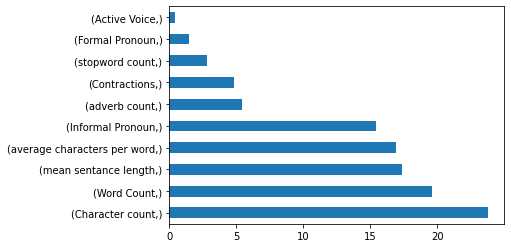

In [304]:
from matplotlib import pyplot as plt
from sklearn import svm

features_names = list(x_train.columns)
pd.Series(abs(clf.coef_[0]), index=x_train.columns).nlargest(10).plot(kind='barh')

In [305]:
# Converting the trained model into a pickle file
import pickle
with open('formality_model.pkl','wb') as f:
    pickle.dump(logreg,f)

In [309]:
with open('formality_model.pkl', 'rb') as f:
    lr_loaded = pickle.load(f)

lr_loaded.predict(x_train[0:2])

array([1, 1])

In [310]:
lr_loaded.predict_proba(x_train[0:2])

array([[0.06120803, 0.93879197],
       [0.21671407, 0.78328593]])